# *KMNIST*

In [1]:
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import urllib.request
from PIL import Image
from io import BytesIO
import random

import tensorflow as tf
from keras.models import Sequential, Model, save_model, load_model
from keras.applications import vgg16
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical, plot_model, set_random_seed

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

plt.rcParams['font.family'] = 'Malgun Gothic'
warnings.filterwarnings(action='ignore')

In [2]:
np.random.seed(42)
tf.random.set_seed(42)
set_random_seed(42)

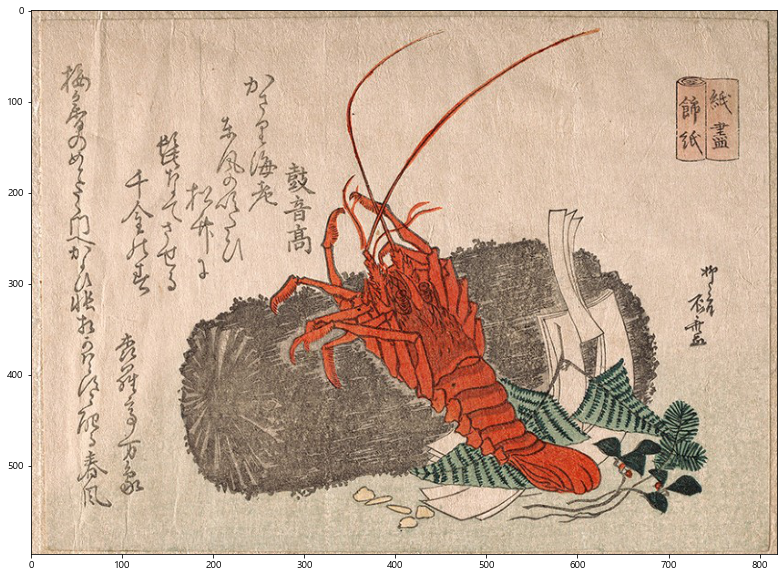

In [3]:
lob=Image.open('Lobster.jpg')
plt.figure(figsize = (20,10))
plt.imshow(lob)

---
## 데이터 불러오기

In [4]:
PATH='./dataset/'

# train data & label => x_train, y_train"
train_images_path = PATH + "kmnist-train-imgs.npz"
train_labels_path = PATH + "kmnist-train-labels.npz"

# test data & label => x_test, y_test
test_images_path = PATH + "kmnist-test-imgs.npz"
test_labels_path = PATH + "kmnist-test-labels.npz"

In [5]:
# npz파일 load하기
train_images = np.load(train_images_path)['arr_0']
train_labels = np.load(train_labels_path)['arr_0']
test_images = np.load(test_images_path)['arr_0']
test_labels = np.load(test_labels_path)['arr_0']

In [6]:
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

---
## 데이터 살펴보기

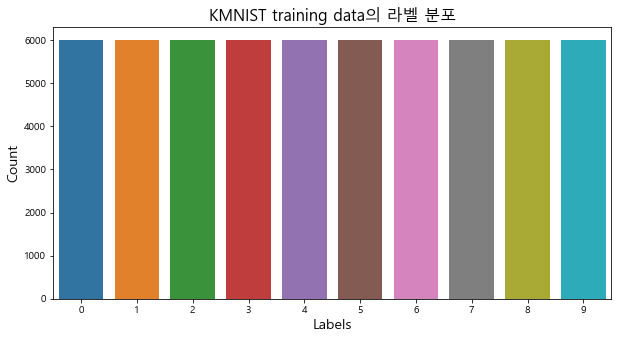

In [7]:
# 라벨값 확인
labels=np.unique(train_labels)
# 라벨값 빈도수 확인
frequency_count = np.bincount(train_labels)

# 시각화 
plt.figure(figsize=(10,5))
sns.barplot(x=labels, y=frequency_count);
plt.title("KMNIST training data의 라벨 분포", fontsize=16)
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

- train data의 각 label에 대한 무작위 샘플을 얻기
- 각 캐릭터(label)의 이미지가 어떻게 생겼는지, 같은 클래스의 샘플 간 변동은 어느 정도인지 알아보기 위함
- 어떻게 정확하게 그룹화할 수 있을까?

In [8]:
random_samples=[]
for i in range(10):
    samples = train_images[np.where(train_labels == i)][:10]
    random_samples.append(samples)
    
# list -> array 형변환
random_samples = np.array(random_samples)

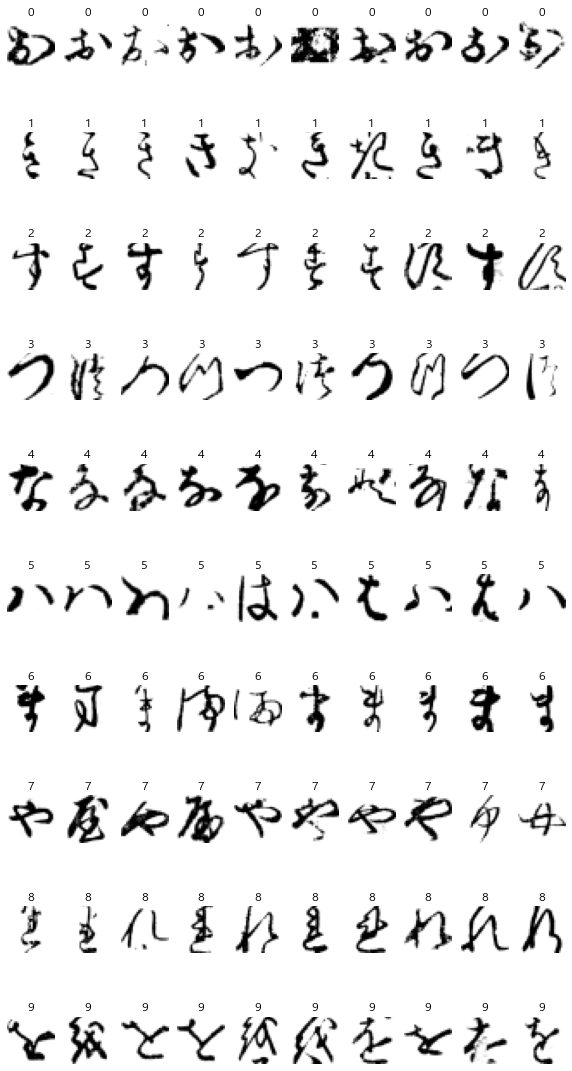

In [9]:
# random_samples 시각화
figure, axes = plt.subplots(10,10, figsize=(10,20))
for i, j in enumerate(random_samples):
    for n in range(10):
        axes[i, n].imshow(random_samples[i][n], cmap=plt.cm.binary)

        axes[i, n].set_title(str(i))
        axes[i, n].axis('off') # 테두리 제거, x, y축 눈금 제거?
        axes[i, n].set_aspect('equal') # x, y축 비율

---
## t-SNE & UMAP
- 고차원 데이터의 시각화
- t-SNE => 계산 비용이 큼, t-SNE의 sklearn 구현 속도 느림. 단일 코어에서 실행되며 메모리가 사용량이 매우 큼. => 샘플 수를 최대 5000으로 제한(사용자 재량)
- UMAP : 상대적으로 연산속도 빠름, 쉬운 파라미터, 30000 ~ 50000 정도의 더 큰 샘플 사이즈를 사용(사용자 재량)

- 차원축소의 시각화

In [164]:
idx = np.random.choice(60000, size=8000, replace=False)
train_sample = train_images.reshape(60000, -1)[idx, :]
label_sample = train_labels[idx]

# 2D로 표현
# # t-SNE 객체 생성 => t-SNE fit_transform
embeddings = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(train_sample)

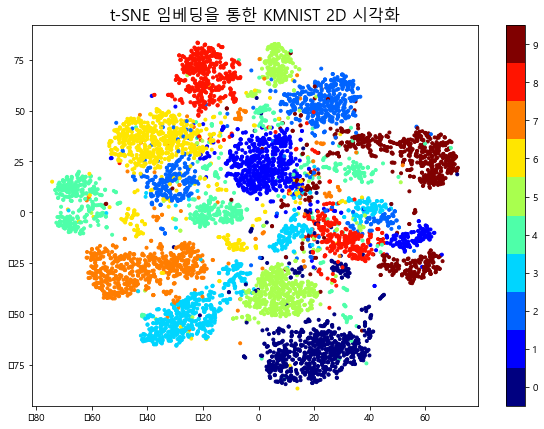

In [165]:
# TSNE embedding
visualize_x = embeddings[:, 0]
visualize_y = embeddings[:, 1]

plt.figure(figsize=(10,7))
plt.title("t-SNE 임베딩을 통한 KMNIST 2D 시각화", fontsize=16)
plt.scatter(visualize_x, visualize_y, c=label_sample, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

In [12]:
# Let's try UMAP now.
nb_indices = 10000
random_indices, random_train_images, random_train_labels, labels = get_random_samples(nb_indices)

embedding = umap.UMAP(n_components=2, metric='correlation', min_dist=0.8)
random_train_2D = embedding.fit_transform(random_train_images)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111) #projection='3d')

for i, label in zip(labels, labels):
    sns.scatterplot(random_train_2D[random_train_labels == i, 0], 
                random_train_2D[random_train_labels == i, 1], 
                label=label, s=15)
plt.title("Visualiza KMNIST embeddings using UMAP ", fontsize=16)
plt.legend()
plt.show()

---
# *Conv2D*

In [13]:
# Dense할 때는 펴줘야 함.
# x_train_Dense=train_images.reshape(-1, 28*28)/255.0
# x_test_Dense=test_images.reshape(-1, 28*28)/255.0
# x_train_Dense.shape, type(x_train_Dense), x_test_Dense.shape, type(x_test_Dense)

In [14]:
# OHE를 하지 않았을 때 sparse_categorical_crossentropy
y_train=train_labels
y_test=test_labels

# complie할 때 loss='categorical_crossentropy'를 사용하고 싶다면, convert class vectors to binary class matrices
# y_train = to_categorical(train_labels, num_classes)
# y_test = to_categorical(test_labels, num_classes)

In [15]:
y_train.shape, type(y_train), y_test.shape, type(y_test)

((60000,), numpy.ndarray, (10000,), numpy.ndarray)

In [16]:
# model_Dense = Sequential()

# model_Dense.add(Dense)

In [17]:
x_train = train_images/255.0
x_test = test_images/255.0

In [18]:
# 모델 구성
model = Sequential()

model.add(Conv2D(32, kernel_size=(3), # 자동으로 (3,3)
                 activation='relu',
                 input_shape=(28, 28, 1))) # (28, 28), 1은 흑백
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # 축소
model.add(Dropout(0.25)) # 과적합 방지
model.add(Flatten()) # 펼침
model.add(Dense(128, activation='relu')) # 펼치고 Dense하면 정확도 상승
model.add(Dropout(0.5)) # 과적합 방지
model.add(Dense(10, activation='softmax')) # 출력층

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

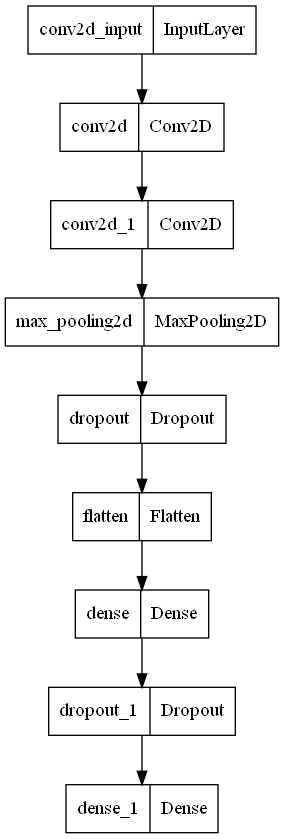

In [20]:
plot_model(model)

In [21]:
# 모델 생성
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
# # callback
# model_ckpt_CB = ModelCheckpoint(filepath='./KMNIST_ckpt/',
#                                save_best_only=True)

In [23]:
# 모델 학습
Conv2D_result = model.fit(x_train, y_train, 
                          batch_size=128, 
                          epochs=5, 
                          validation_data=(x_test, y_test))

Epoch 1/5
469/469 [==============================] - 59s 124ms/step - loss: 0.4027 - accuracy: 0.8777 - val_loss: 0.3413 - val_accuracy: 0.8985
Epoch 2/5
469/469 [==============================] - 60s 129ms/step - loss: 0.1661 - accuracy: 0.9499 - val_loss: 0.2821 - val_accuracy: 0.9224
Epoch 3/5
469/469 [==============================] - 60s 129ms/step - loss: 0.1243 - accuracy: 0.9622 - val_loss: 0.2192 - val_accuracy: 0.9399
Epoch 4/5
469/469 [==============================] - 61s 130ms/step - loss: 0.0981 - accuracy: 0.9696 - val_loss: 0.2124 - val_accuracy: 0.9415
Epoch 5/5
469/469 [==============================] - 60s 128ms/step - loss: 0.0801 - accuracy: 0.9751 - val_loss: 0.2106 - val_accuracy: 0.9454


In [24]:
x_train.shape

(60000, 28, 28)

---
## 모델 평가

In [177]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.2106 - accuracy: 0.9454


[0.21057599782943726, 0.9453999996185303]

In [178]:
# plt.figure(figsize=(20, 8))
# plt.subplot(121)
# # loss 비교
# plt.plot(Conv2D_result.epoch, Conv2D_result.history['loss'],label='Train loss')
# plt.plot(Conv2D_result.epoch, Conv2D_result.history['val_loss'],label='validation loss')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.legend()

# plt.subplot(122)
# # accuracy 비교
# plt.plot(Conv2D_result.epoch, Conv2D_result.history['accuracy'], label='Train accuracy')
# plt.plot(Conv2D_result.epoch, Conv2D_result.history['val_accuracy'],label='validation accuracy')
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.legend()

# plt.show()

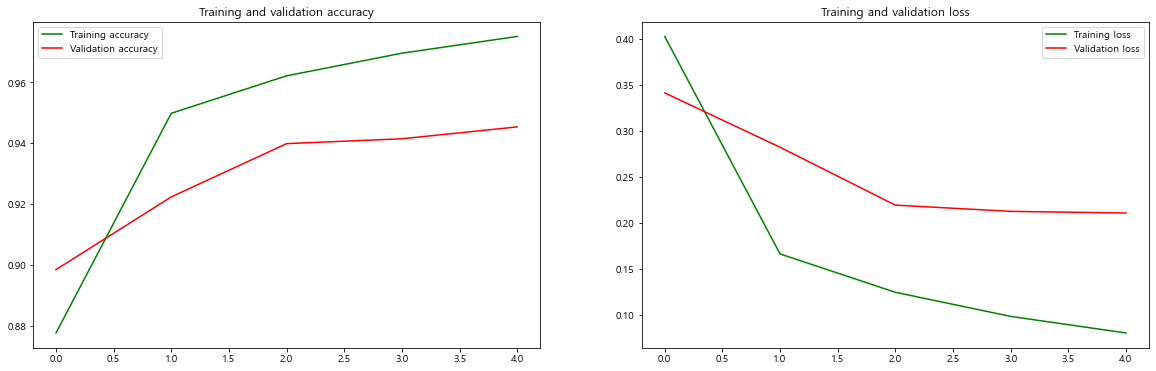

In [179]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(20, 6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(Conv2D_result)

---
## 테스트 데이터로 예측

In [152]:
labels_dict = dict([(0, u"\u304A - O"), (1, u"\u304D - Ki"), (2, u"\u3059 - Su"), (3, u"\u3064 - tsu"),
                    (4, u"\u306A - Na"), (5, u"\u306F- Ha"), (6, u"\u307E - Ma"), (7, u"\u3084 - Ya"),
                    (8, u"\u308C - Re"), (9, u"\u3093 - N")])
print(labels_dict)

{0: 'お - O', 1: 'き - Ki', 2: 'す - Su', 3: 'つ - tsu', 4: 'な - Na', 5: 'は- Ha', 6: 'ま - Ma', 7: 'や - Ya', 8: 'れ - Re', 9: 'ん - N'}


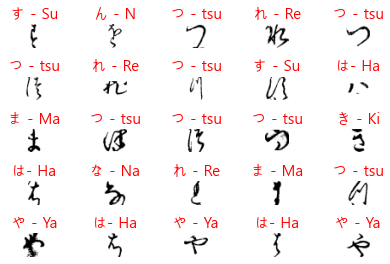

In [153]:
for i in range(25):

    result = model.predict(x_test[i].reshape(-1, 28, 28, 1), verbose=0)
    
    plt.subplot(5,5,i+1)
    plt.tight_layout() # 간격 띄우기
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.title(labels_dict[result.argmax()], fontsize=15, color='red')
    plt.axis('off')
plt.show()

---
## 새로운 데이터로 예측

In [154]:
# url 이미지 출력하고 예측하는 함수
def Pred_Show_UrlImg(model, url):
    
    # 이미지 불러오기
    req = urllib.request.Request(url)
    res = urllib.request.urlopen(req).read()
    urlopen_img = Image.open(BytesIO(res)).resize((28,28))
    test_img_arr = np.array(urlopen_img)/255.0
    
    # 이미지 그래프로 그리기
    plt.imshow(urlopen_img)
    plt.show()
    
    # 예측하기
    result = model.predict(test_img_arr.reshape(28, 28, 1))
    print(f"예측값 : {result}")
    print(f"예측값 종류 : {labels_dict[result.argmax()]}")

In [155]:
# 파일 이미지 출력하고 예측하는 함수
def Pred_Show_Img(model, path):

    # 이미지 불러오고 그래프로 그리기
    img = Image.open(path)
    plt.imshow(img)
    
    # 예측하기
    img=img.resize((28,28))
    pix_img=np.array(img)
    result = np.round(model.predict(pix_img.reshape(-1, 28, 28, 1)), 2)
    print(f"예측값 : {result}")
    print(f"예측값 종류 : {labels_dict[result.argmax()]}")

In [158]:
# 테스트할 자료
test_RE = './KMNIST_test/레(re).jpg'
test_SU = './KMNIST_test/수(su).jpg'
test_HA02 = './KMNIST_test/하2(ha).jpg'
test_HA = './KMNIST_test/하(ha).jpg'
test_SU02 = './KMNIST_test/스(su).jpg'
test_KI = './KMNIST_test/키(ki).jpg'
test_MA = './KMNIST_test/마(ma).jpg'
test_YA = './KMNIST_test/야(ya).jpg'
test_jpg_list=[test_RE, test_SU, test_HA02, test_HA, test_SU02, test_KI, test_MA, test_YA]

# **0: 'お', 1: 'き', 2: 'す', 3: 'つ', 4: 'な', 5: 'は', 6: 'ま', 7: 'や', 8: 'れ', 9: 'ん'**

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


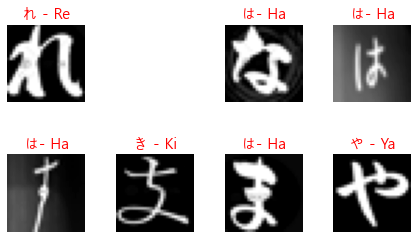

In [159]:
i = 0
for n in test_jpg_list:
    img = Image.open(n)
    img = img.convert("L") # 흑백으로 불러오기
    img=img.resize((28,28))
    img_arr = np.array(img)
    img_arr=img_arr.reshape(-1, 28, 28, 1)
    result = np.round(model.predict(img_arr.reshape(-1,28,28,1), verbose=0), 5)
    print(result)

    plt.subplot(2,4,i+1)
    plt.tight_layout() # 간격 띄우기
    plt.imshow(img, cmap=plt.cm.binary)
    plt.title(labels_dict[result.argmax()], fontsize=15, color='red')
    plt.axis('off')

    i += 1
    